## Link Prediction

In [1]:
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GNNExplainer
from torch_geometric.utils import negative_sampling

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(
        num_val=0.05, 
        num_test=0.1, 
        is_undirected=True, 
        add_negative_train_samples=False
    ),
])

dataset = Planetoid("../data/Cora", name='Cora', transform=transform)

# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.

train_data, val_data, test_data = dataset[0]

In [3]:
from torch import nn
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        # self.W1 = nn.Linear(out_channels * 2, out_channels)
        # self.W2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        # z = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), dim=1)
        # return self.W2(F.relu(self.W1(z)).squeeze())
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    
    def forward(self, x, edge_index, data=None):
        z = self.encode(x, edge_index)
        out = model.decode(z, edge_index)
        return torch.vstack((-out, out)).T


model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [4]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 010, Loss: 0.6760, Val: 0.7056, Test: 0.6850
Epoch: 020, Loss: 0.6362, Val: 0.7347, Test: 0.7450
Epoch: 030, Loss: 0.5408, Val: 0.8071, Test: 0.7956
Epoch: 040, Loss: 0.4970, Val: 0.8744, Test: 0.8550
Epoch: 050, Loss: 0.4791, Val: 0.8868, Test: 0.8700
Epoch: 060, Loss: 0.4668, Val: 0.9085, Test: 0.8921
Epoch: 070, Loss: 0.4549, Val: 0.9196, Test: 0.8975
Epoch: 080, Loss: 0.4508, Val: 0.9194, Test: 0.9013
Epoch: 090, Loss: 0.4462, Val: 0.9235, Test: 0.9094
Epoch: 100, Loss: 0.4410, Val: 0.9298, Test: 0.9151
Final Test: 0.9151


## GNNExplainer

In [5]:
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.nn.models.explainer import clear_masks, set_masks

EPS = 1e-15


class EdgeGNNExplainer(GNNExplainer):
    def _loss(self, log_logits, prediction, edge_idx = None):
        if self.return_type == 'regression':
            if edge_idx is not None and edge_idx >= 0:
                loss = torch.cdist(log_logits[edge_idx], prediction[edge_idx])
            else:
                loss = torch.cdist(log_logits, prediction)
        else:
            if edge_idx is not None and edge_idx >= 0:
                loss = -log_logits[edge_idx, prediction[edge_idx]]
            else:
                loss = -log_logits[0, prediction[0]]

        if self.allow_edge_mask:
            m = self.edge_mask.sigmoid()
            edge_reduce = getattr(torch, self.coeffs['edge_reduction'])
            loss = loss + self.coeffs['edge_size'] * edge_reduce(m)
            ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
            loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        node_feat_reduce = getattr(torch, self.coeffs['node_feat_reduction'])
        loss = loss + self.coeffs['node_feat_size'] * node_feat_reduce(m)
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss
    
    def edge_subgraph(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)
        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx_1, self.num_hops + 1, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self._flow())
        
        mapping_2 = (subset == node_idx_2).nonzero()[0].item()
        mapping = torch.tensor([mapping[0], mapping_2])
        
        x = x[subset]
        kwargs_new = {}
        for key, value in kwargs.items():
            if torch.is_tensor(value) and value.size(0) == num_nodes:
                kwargs_new[key] = value[subset]
            elif torch.is_tensor(value) and value.size(0) == num_edges:
                kwargs_new[key] = value[edge_mask]
            else:
                kwargs_new[key] = value  # TODO: this is not in PGExplainer
        return x, edge_index, mapping, edge_mask, subset, kwargs_new
    
    
    def explain_edge(self, node_idx_1, node_idx_2, x, edge_index, **kwargs):
        self.model.eval()
        self._clear_masks()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.edge_subgraph(node_idx_1, node_idx_2, x, edge_index, **kwargs)
        
        # edge mapping
        mapping = torch.nonzero(torch.all(edge_index.T==mapping, dim=1)).item()

        # Get the initial prediction.
        prediction = self.get_initial_prediction(x, edge_index, **kwargs)

        self._initialize_masks(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            set_masks(self.model, self.edge_mask, edge_index, apply_sigmoid=True)
            parameters = [self.node_feat_mask, self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain edge {node_idx_1, node_idx_2}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.sigmoid()
            out = self.model(x=h, edge_index=edge_index, **kwargs)
            loss = self.get_loss(out, prediction, mapping).sum()
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()

        if self.allow_edge_mask:
            edge_mask = self.edge_mask.new_zeros(num_edges)
            edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()
        else:
            edge_mask = torch.zeros(num_edges)
            edge_mask[hard_edge_mask] = 1

        self._clear_masks()

        return node_feat_mask, edge_mask

In [6]:
x = train_data.x  # same for val/test
edge_index = train_data.edge_index  # same as val, test is different, unsure why (TODO)

node_idx_1 = 1334
node_idx_2 = 1701

explainer = EdgeGNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_edge(node_idx_1, node_idx_2, x, edge_index)

Explain edge (1334, 1701): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 74.43it/s]


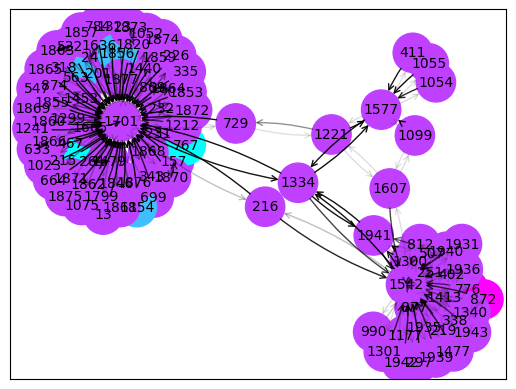

In [7]:
ax, G = explainer.visualize_subgraph(node_idx_1, edge_index, edge_mask, y=train_data.y)
plt.show()